# Project 4: Optimal Vehicle State Estimation

Max Schrader

In [1]:
# # !pip install scipy
# !pip install scipy
# !pip install plotly
# !pip install dubins
# !python -mpip install --only-binary numpy

In [65]:
import math
from dataclasses import dataclass
from typing import List
from IPython.display import display

import sympy
import dubins
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from scipy.interpolate import interp2d
from scipy.stats import multivariate_normal

sympy.init_printing(use_latex='mathjax')
pio.templates.default = "ggplot2"
pio.renderers.default = "plotly_mimetype"

In [4]:
rad_to_deg = 180 / math.pi

## Finding Dubin's Path

In [3]:
R = 5  # given
dt = 0.01

In [5]:
q0 = (0, -15, -90 / rad_to_deg)
q1 = (-5, 20, -180 / rad_to_deg)
turning_radius = R
step_size = dt

path = dubins.shortest_path(q0, q1, R)
configurations, x = path.sample_many(step_size)

In [6]:
len(configurations)

5519

In [7]:
def plot_dubin(*args):
    fig = go.Figure()
    
    for name,  mode, path_list, in args:
        _x = [p[0] for p in path_list]
        _y = [p[1] for p in path_list]
        _theta = [p[2] * rad_to_deg for p in path_list]
        
        fig.add_trace(
            go.Scatter(
                x=_x,
                y=_y,
                text=_theta,
                name=name,
                mode=mode,
                hovertemplate="Angle: %{text}<br>X: %{x}<br>Y: %{y}"
            )
        )
        
        if "dubin" in name.lower():
            fig.add_trace(
                go.Scatter(
                    x=_x[::len(_x) - 1],
                    y=_y[::len(_y) - 1],
                    name="End Points",
                    mode="markers",
                    marker_size=8,
                    marker_color="black"
                )
            )
    
    fig.update_layout(
        margin=dict(l=20, r=20, b=20, t=20),
        height=600, width=600,
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis_zeroline=True,
        yaxis_zeroline=True,
        xaxis_zerolinecolor='#969696',
        yaxis_zerolinecolor='#969696',
        xaxis_range=[-25, 25],
        yaxis_range=[-25, 25],
    )
    
    return fig

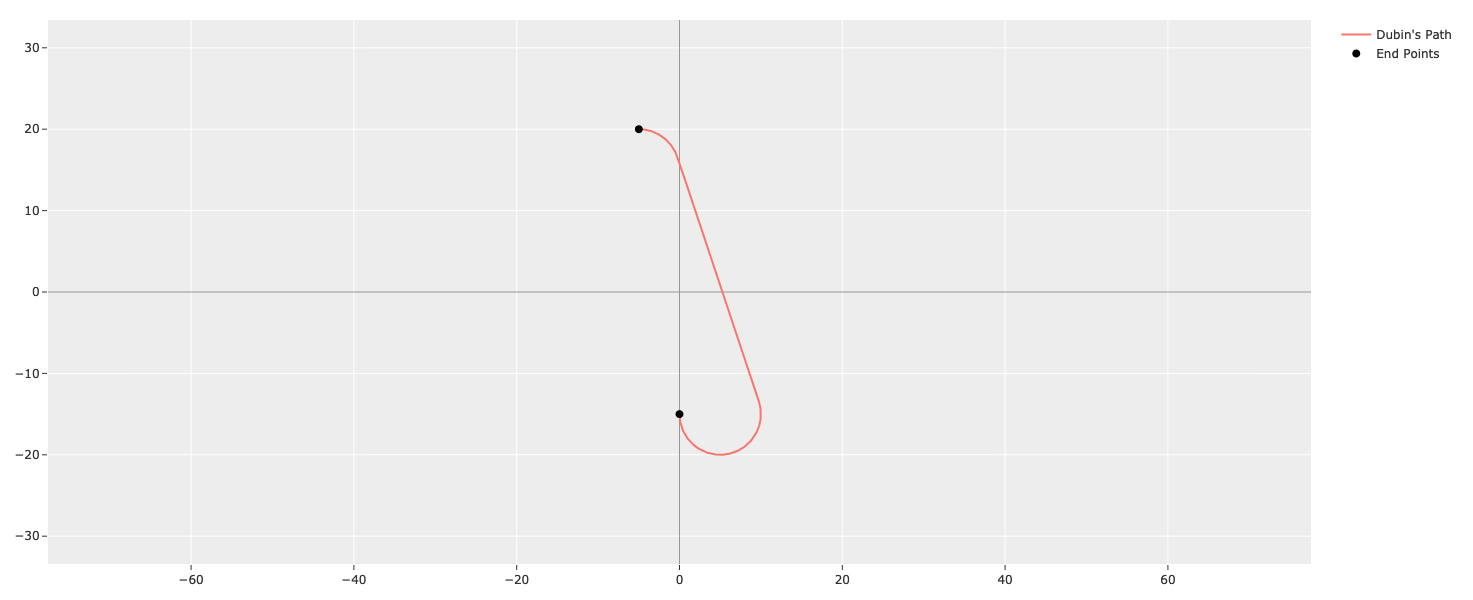

In [8]:
plot_dubin(["Dubin's Path", "lines", configurations]).show()

## Creating the Car Model

In [9]:
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix

In [10]:
d_t, s = symbols('dt, s')
a = Matrix([
    [x + d_t * s * sympy.cos(theta)],
    [y + d_t * s * sympy.sin(theta)],
    [theta]
])

A = a.jacobian(Matrix([x, y, theta]))
A

⎡1  0  -dt⋅s⋅sin(θ)⎤
⎢                  ⎥
⎢0  1  dt⋅s⋅cos(θ) ⎥
⎢                  ⎥
⎣0  0       1      ⎦

In [11]:
y_1, x_1, y_2, x_2 = symbols('y_1, x_1, y_2, x_2')
b = Matrix([
    [sympy.atan2((y - y_1), (x - x_1))],
    [sympy.atan2((y - y_2), (x - x_2))],
    [theta]
])
B = b.jacobian(Matrix([x, y, theta]))
B

⎡       -y + y₁                 x - x₁          ⎤
⎢─────────────────────  ─────────────────────  0⎥
⎢        2           2          2           2   ⎥
⎢(x - x₁)  + (y - y₁)   (x - x₁)  + (y - y₁)    ⎥
⎢                                               ⎥
⎢       -y + y₂                 x - x₂          ⎥
⎢─────────────────────  ─────────────────────  0⎥
⎢        2           2          2           2   ⎥
⎢(x - x₂)  + (y - y₂)   (x - x₂)  + (y - y₂)    ⎥
⎢                                               ⎥
⎣          0                      0            1⎦

In [64]:
class LTI:
    
    def __init__(self, s: float, dt: float, x0: tuple, dubins_path: list, r: float, q1: tuple):
        
        # self.dubins_heading = interp2d(*[[d[i] for d in dubins_path] for i in range(3)])
        self.q1 = q1
        self.r = r
        self.s = s
        self.d_t = dt
        self.x0 = np.array(x0).T
        self.x_last = self.x0.copy()
        self.trajectory = []

        # re-import to avoid vairable naming issues 
        from sympy.abc import x, y, u, v, w, R, theta
    
        d_t, s = symbols('dt, s')
        y_1, x_1, y_2, x_2 = symbols('y_1, x_1, y_2, x_2')
        self.A = Matrix([
            [x + d_t * s * sympy.cos(theta)],
            [y + d_t * s * sympy.sin(theta)],
            [theta]
        ])
        
        self.B = Matrix([
            [0],
            [0],
            [u * d_t]
        ])
        
        self.A_j = self.A.jacobian(Matrix([x, y, theta]))
        
        self.C = Matrix([
            [sympy.atan2((y - y_1), (x - x_1))],
            [sympy.atan2((y - y_2), (x - x_2))],
            [theta]
        ])
        
        self.C_j = self.C.jacobian(Matrix([x, y, theta]))
    
    def measure(self, x: float, x1: float, y: float, y1: float, x2: float, y2: float) -> np.ndarray:
        return np.array(
            self.C.evalf(subs={
                'x': x,
                'y': y,
                'x_1': x_1,
                'y_1': y_1,
                'x_2': x_2,
                'y_2': y_2,
                'theta': theta
            })
        ).astype(float)
    
    
    def F(self, x, y, theta) -> np.ndarray:
        return np.array(self.A_j.evalf(subs={
                'x': x,
                'y': y,
                'theta': theta,
                's': self.s,
                'dt': self.d_t
        })).astype(float)
    
    def H(self, x, y, theta) -> np.ndarray:
        return np.array(self.C_j.evalf(subs={
                'x': x,
                'y': y,
                'theta': theta
        })).astype(float)
    
    
    def f(self, x, y, theta, u) -> np.ndarray:
        return np.array(self.A.evalf(subs={
                'x': x,
                'y': y,
                'theta': theta
                }
            )).astype(float) 

    
    def h(self, x, y, theta) -> np.ndarray:
        return np.array(self.C.evalf(subs={
                'x': x,
                'y': y,
                'theta': theta
        })).astype(float)
    
    def x_t(self, x, y, theta) -> np.ndarray:
        x_t = np.array(self.A.evalf(subs={
                'x': x,
                'y': y,
                'theta': theta,
                's': self.s,
                'dt': self.d_t
        })).astype(float) + self.x_last
    
        
        self.x_last = x.copy()
        
        return x
    
    def find_heading(self, dubin_path, x, y) -> theta:
        distance = [((_p[0] - x) ** 2 + (_p[1] - y) ** 2) ** (1/2) for _p in dubin_path]
        return np.argmin(distance)
    
    def x_t_noise(self, x, dubins_path, i=0) -> np.ndarray:
        while True:
            # u = dubins.shortest_path(x[-1], self.q1, self.R).sample(1)[-1]  #
            # du = x[-1][-1] - u
            # desired_heading = self.dubins_heading(x[-1][0], x[-1][1])[0]
            idx = self.find_heading(dubins_path, x[-1][0], x[-1][1])
            du = dubins_path[idx][2]
            u = du
            # u =  min(max(du, -1 / self.R), 1 / self.R)
            # R
            if idx >= (len(dubins_path) - 2) or i > (len(self.s) - 1):
                break

            x.append(
                np.array(
                    self.A.evalf(
                        subs={
                            'x': x[-1][0],
                            'y': x[-1][1],
                            'theta': u,  # x[-1][-1],  # x[-1][2], # desired_heading, # x[-1][2],
                            's': self.s[i],
                            # 'u': u,
                            'dt': self.d_t
                        }
                    )
                ).astype(float).T[0]
            )
            # consume the list
            return self.x_t_noise(x, dubins_path, i+1)
        
        self.trajectory = x

### Calculating the True Vehicle Path

In [58]:
lti = LTI(s=np.random.normal(1, .05, 240), dt=0.5, x0=configurations[0], dubins_path=configurations, r=5, q1=q1)
lti.x_t_noise(x=[configurations[0]], dubins_path=configurations,)

#### Plotting the Path

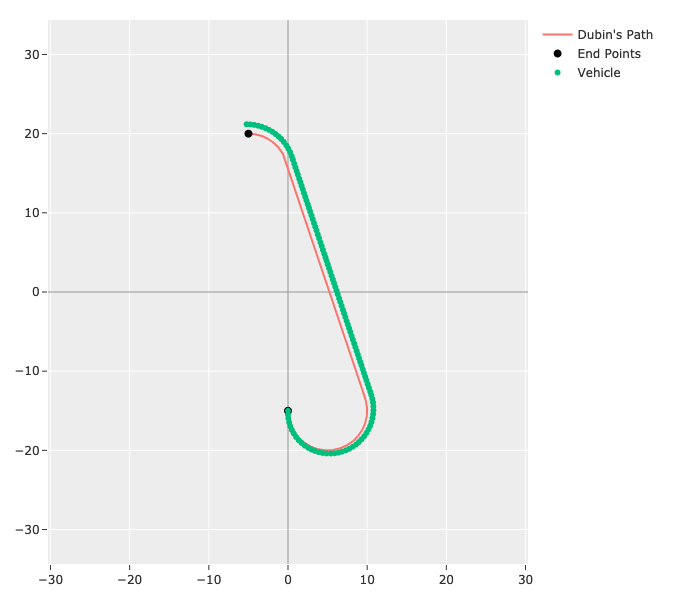

In [59]:
plot_dubin(["Dubin's Path", "lines", configurations], ["Vehicle", "markers", lti.trajectory]).show()

## Implementing a Simple, Noisy Bearing Calc

In [15]:
@dataclass
class Radar:
    x: float
    y: float
    v: float


In [48]:
# I added in the distance from the radar to make plotting easier
def two_radar_est(vehicle_path: list, radar_1: Radar, radar_2: Radar) -> list:
    y = []
    f_var = multivariate_normal(mean=np.zeros(3), cov=np.diag([radar_1.v, radar_2.v, 5 / rad_to_deg]))
    for x in vehicle_path:
        var = f_var.rvs()
        y.append(
            np.array(
                (
                    math.atan2(x[1] - radar_1.y, x[0] - radar_1.x) * rad_to_deg + var[0],
                    math.atan2(x[1] - radar_2.y, x[0] - radar_2.x) * rad_to_deg + var[1],
                    x[2],
                    np.linalg.norm(np.array(x[:-1]) - np.array((radar_1.x, radar_1.y))),
                    np.linalg.norm(np.array(x[:-1]) - np.array((radar_2.x, radar_2.y)))
                )
            )
        )
    return y

### Radars at (−15, −10) and (−15, 5)

In [49]:
radar_1 = Radar(x=-15, y=-10, v=9)
radar_2 = Radar(x=-15, y=5, v=9)
bearing = two_radar_est(vehicles_path, Radar(x=-15, y=-10, v=9), Radar(x=-15, y=5, v=9))

#### Plotting the Bearing

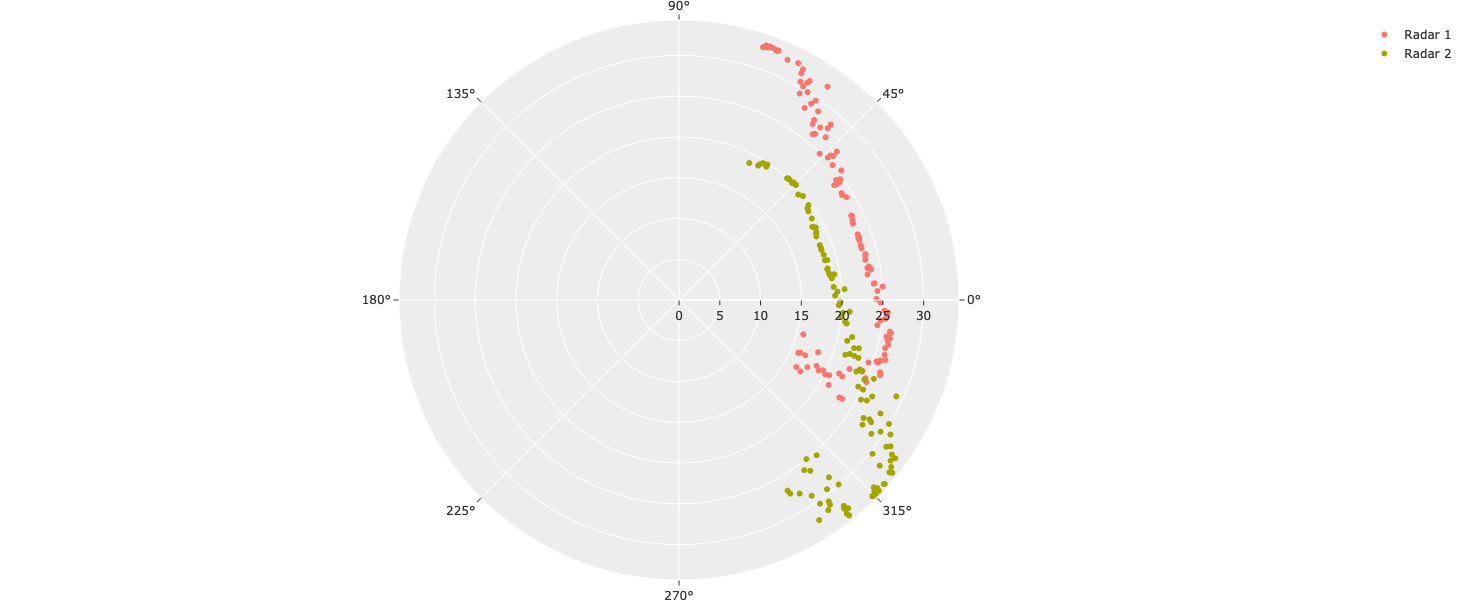

In [50]:
fig = go.Figure()

fig.add_trace(
    go.Scatterpolar(
        r = [b[3] for b in bearing],
        theta = [b[0] for b in bearing],
        mode = 'markers',
        name="Radar 1"
    )
)

fig.add_trace(
    go.Scatterpolar(
        r = [b[4] for b in bearing],
        theta = [b[1] for b in bearing],
        mode = 'markers',
        name="Radar 2"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    height=600, width=600,
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    xaxis_range=[-25, 25],
    yaxis_range=[-25, 25],
)

fig.show()

### using the bearing and the distance to plot in XY

In [51]:
x_y_1 = [(radar_1.x + np.cos(b[0] / rad_to_deg) * b[3], radar_1.y + np.sin(b[0] / rad_to_deg) * b[3], b[2]) for b in bearing]
x_y_2 = [(radar_2.x + np.cos(b[1] / rad_to_deg) * b[4], radar_2.y + np.sin(b[1] / rad_to_deg) * b[4], b[2]) for b in bearing]

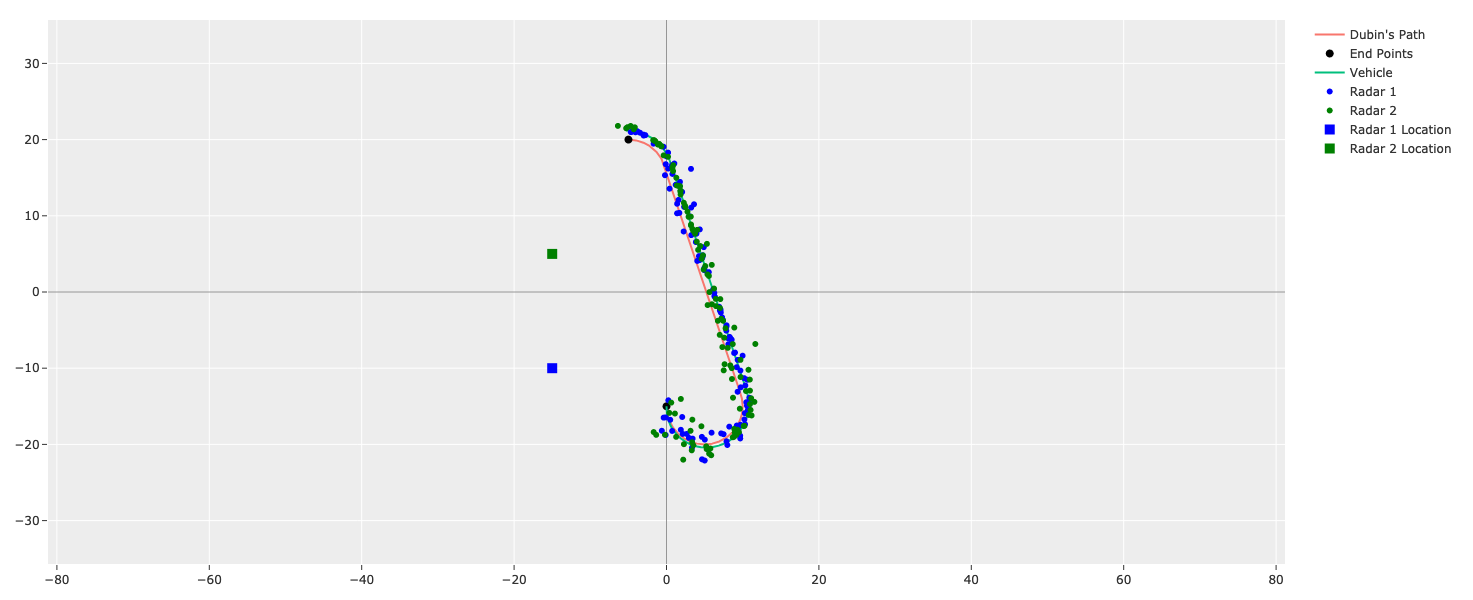

In [52]:
fig = plot_dubin(["Dubin's Path", "lines", configurations], 
           ["Vehicle", "lines", vehicles_path], 
           ["Radar 1", "markers", x_y_1],
           ["Radar 2", "markers", x_y_2])

fig.data[3].line.color = "blue"
fig.data[4].line.color = "green"

fig.add_trace(
    go.Scatter(
        x=[radar_1.x],
        y=[radar_1.y],
        name='Radar 1 Location',
        mode="markers",
        marker_size=10,
        marker_color="blue",
        marker_symbol="square"
    )
)

fig.add_trace(
    go.Scatter(
        x=[radar_2.x],
        y=[radar_2.y],
        name='Radar 2 Location',
        mode="markers",
        marker_size=10,
        marker_color="green",
        marker_symbol="square"
    )
)


fig.show()

### Radars at (−100, −10) and (−100, 5)

In [53]:
radar_1 = Radar(x=-100, y=-10, v=9)
radar_2 = Radar(x=-100, y=5, v=9)
bearing = two_radar_est(vehicles_path, radar_1, radar_2)

#### Plotting the Bearing

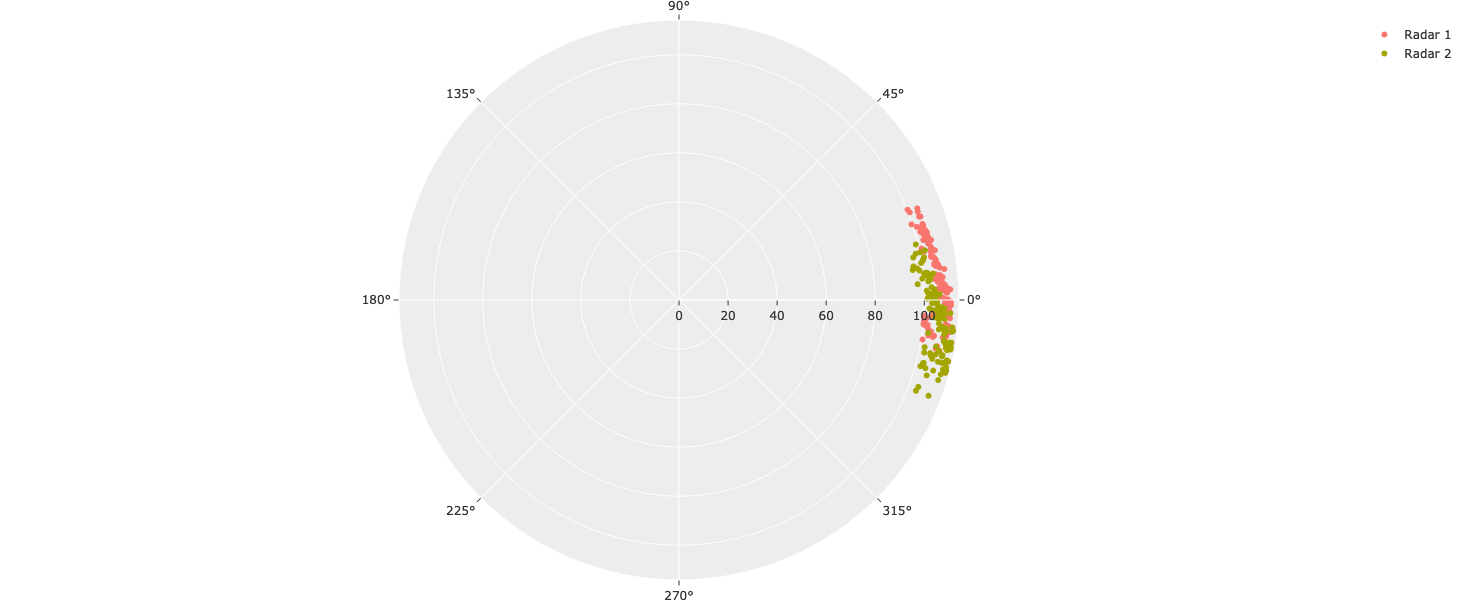

In [54]:
fig = go.Figure()

fig.add_trace(
    go.Scatterpolar(
        r = [b[3] for b in bearing],
        theta = [b[0] for b in bearing],
        mode = 'markers',
        name="Radar 1"
    )
)

fig.add_trace(
    go.Scatterpolar(
        r = [b[4] for b in bearing],
        theta = [b[1] for b in bearing],
        mode = 'markers',
        name="Radar 2"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    height=600, width=600,
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    xaxis_range=[-25, 25],
    yaxis_range=[-25, 25],
)

fig.show()

### using the bearing and the distance to plot in XY

In [55]:
x_y_1 = [(radar_1.x + np.cos(b[0] / rad_to_deg) * b[3], radar_1.y + np.sin(b[0] / rad_to_deg) * b[3], b[2]) for b in bearing]
x_y_2 = [(radar_2.x + np.cos(b[1] / rad_to_deg) * b[4], radar_2.y + np.sin(b[1] / rad_to_deg) * b[4], b[2]) for b in bearing]

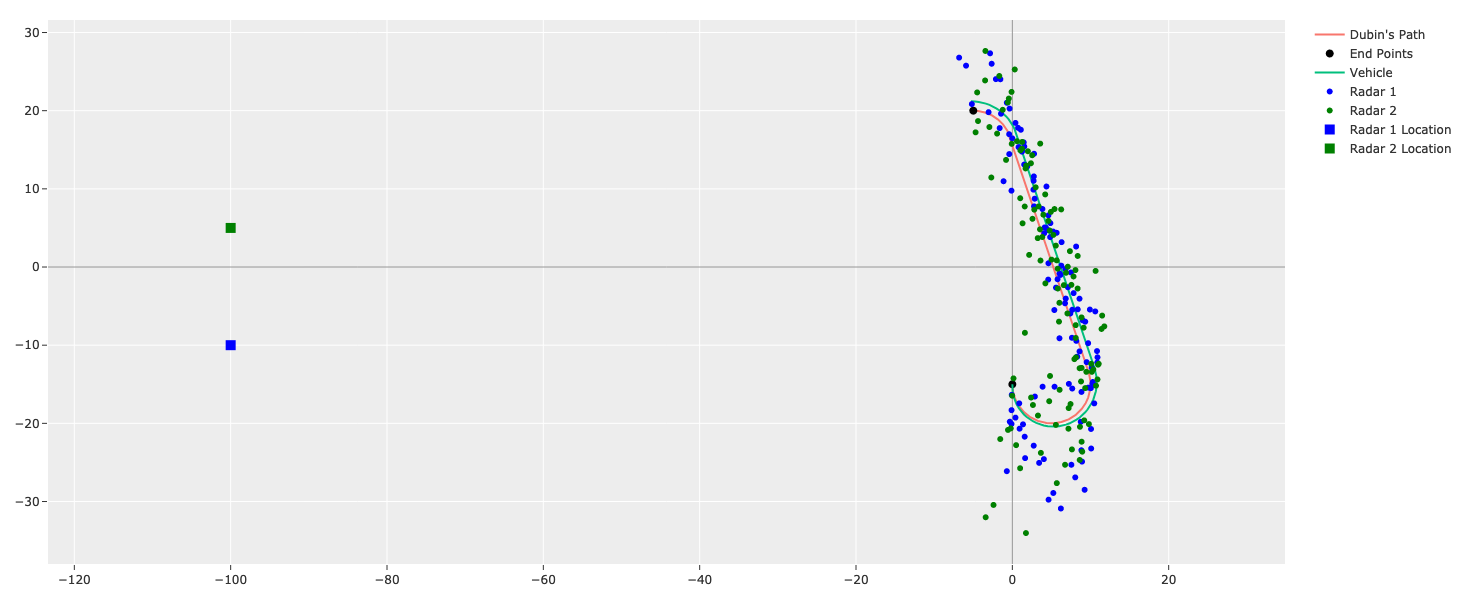

In [56]:
fig = plot_dubin(["Dubin's Path", "lines", configurations], 
           ["Vehicle", "lines", vehicles_path], 
           ["Radar 1", "markers", x_y_1],
           ["Radar 2", "markers", x_y_2])

fig.data[3].line.color = "blue"
fig.data[4].line.color = "green"

fig.add_trace(
    go.Scatter(
        x=[radar_1.x],
        y=[radar_1.y],
        name='Radar 1 Location',
        mode="markers",
        marker_size=10,
        marker_color="blue",
        marker_symbol="square"
    )
)

fig.add_trace(
    go.Scatter(
        x=[radar_2.x],
        y=[radar_2.y],
        name='Radar 2 Location',
        mode="markers",
        marker_size=10,
        marker_color="green",
        marker_symbol="square"
    )
)


fig.update_layout(
    xaxis_range=None,
    yaxis_range=None
)


fig.show()

## Estimate the Postition of the Ground Vehicle Using EKFs

In [68]:
class EKF:
    
    def __init__(self, lti: LTI, R: np.ndarray, Q: np.ndarray, radar: List[Radar, ]) -> None:
        self.lti = lti
        self.radars = radars
        
        dim_x = self.lti.x0.shape[0]
        dim_y = np.array(self.lti.A_j).shape[1]
        
        self.x = np.zeros_like(self.lti.x0)
        
        self.P_posteriori = np.eye(dim_x)
        self.P_priori = self.P_posteriori.copy()
        
        # initialize empty matrices
        self.K = np.zeros((dim_x, dim_y))
        self._I = np.eye((dim_x, dim_y))
        
        # uncertainty
        self.R = R  
        self.Q = Q 
        
        # Gain Matrices
        self.L = np.eye(self.Q.shape[0])
        self.M = np.eye(self.R.shape[0])
    
    def step_car(self, i):
        try:
            return self.lti.trajectory[i]
        except IndexError:
            return 
        
    def update(self, x, *args, **kwargs) -> None:
        
        # x = self.step_car(iter_)
        y_act = self.lti.measure(x=x[0], 
                                 y=x[1], 
                                 x1=self.radars[0].x, 
                                 x2=self.radars[1].x, 
                                 y1=self.radars[0].y, 
                                 y2=self.radars[1].y,
                                 theta=x[2])
        
        F_j = self.lti.F(*list(x), **kwargs)
        H_j = self.lti.H(*list(x), **kwargs)
        
        # A Priori State Covariance        
        P_priori = F_j @ self.P_posteriori @ F_j.T + self.L @ self.Q @ self.L.T
        
        # Innovation 
        y_k = y_act - self.lti.f(*x)
        
        # Innovation Covariance
        S_k = H_j @ P_prior @ H_j.T + self.M @ self.R @ self.M.T

        # sub-optimal Kalman Gain
        K_k = P_priori @ H_j.T @ np.linalg.inv(S_k)
        
        # a posteriori mean estimate
        x_k_k = x + K_k @ y_k
        
        # P posteriori
        P_k_k = P_priori - K_k @ S_k @ K_k.T
        
        self.P_posteriori = P_k_k.copy()
        
        return x_k_k, y_k, P_k_k, S_k
        
        
    def run(self, states,):
        
        # could also use recursion to do this
        results = []
        i = 0
        while True:
            x_k = self.step_car(i)
            if not x_k:
                break
            
            results.append(
                self.update(x=x_k, )
            )
            
        return results
        

SyntaxError: unexpected EOF while parsing (4197314124.py, line 3)